# Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
from torchvision import datasets # for built-in datasets
from torchvision import transforms

# 1. Convolution function

In [ ]:
def sigmoid(x):
  sigmoid_op = 1 / (1 + np.exp(-x))
  return sigmoid_op

def ReLU(x):
  return np.maximum(0.0, x)

def tanh(x):
  return np.tanh(x)

def PReLU(x):
  alpha = 0.05
  return np.max(0.0, x) + alpha * np.min(0.0, x)

def linear(x):
  return x

def softmax(x):
  return np.exp(x) / np.exp(x).sum()

In [ ]:
def convolve(img, no_of_input_channels, no_of_output_channels, kernel_shape=(3, 3), padding=(0, 0), stride=(1,1), nl_activation_func=ReLU):
  kernel = np.random.randn(no_of_output_channels, no_of_input_channels, kernel_shape[0], kernel_shape[1])
  # kernel = np.ones((no_of_output_channels, no_of_input_channels, kernel_shape[0], kernel_shape[1])) / no_of_output_channels * no_of_input_channels * kernel_shape[0] * kernel_shape[1]
  biases = np.random.randn(no_of_output_channels)
  height_padding = np.zeros((img.shape[0], padding[1], no_of_input_channels))
  width_padding = np.zeros((padding[0], img.shape[1] + 2 * padding[1], no_of_input_channels))

  img = np.concatenate((height_padding, img, height_padding), 1)
  img = np.concatenate((width_padding, img, width_padding), 0)

  res_x = int(((img.shape[0] - kernel_shape[0]) / stride[0]) + 1)
  res_y = int(((img.shape[1] - kernel_shape[1]) / stride[1]) + 1)
  res_img = np.zeros((res_x, res_y, no_of_output_channels))

  for out in range(no_of_output_channels):
    for x in range(0, res_x):
      for y in range(0, res_y):
        for c in range(no_of_input_channels):
          res_img[x, y, out] += np.sum(kernel[out, c] * img[x * stride[0] : x * stride[0] + kernel_shape[0], y * stride[1] : y * stride[1] + kernel_shape[1], c])
        res_img[x, y, out] += biases[out]
        res_img[x, y, out] = nl_activation_func(res_img[x, y, out])
  return kernel, res_img


Input image dimensions: (172, 293, 3)
Output image dimensions: (174, 295, 1)


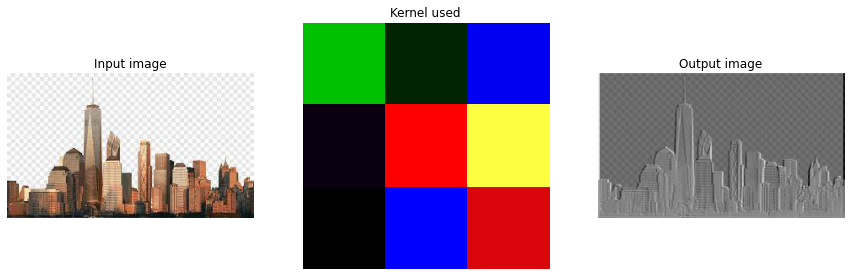

In [ ]:
loc = "some2.jpeg"
img = Image.open(loc).convert('RGB')
img = np.asarray(img)
kernel, res = convolve(img, img.shape[2], 1, padding=(2, 2), nl_activation_func=linear)

print("Input image dimensions: {}".format(img.shape))
print("Output image dimensions: {}".format(res.shape))

fig, axes = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Input image")

axes[1].imshow(kernel[0].transpose((1, 2, 0)))
axes[1].axis('off')
axes[1].set_title("Kernel used")

axes[2].imshow(res[:, :, 0], cmap="gray")
axes[2].axis('off')
axes[2].set_title("Output image")

plt.show()

# 2. Pooling Function

In [ ]:
def max_pooling(x):
  return np.max(x)

def min_pooling(x):
  return np.min(x)

def mean_pooling(x):
  return np.mean(x)

In [ ]:
def pool(activation_map, stride=(3, 3), pooling_func=max_pooling, global_average_pooling=False):
  if global_average_pooling == False:
    img_dims = activation_map.shape
    res_x = img_dims[0] // stride[0]
    res_y = img_dims[1] // stride[1]
    pooled_img = np.zeros((res_x, res_y, img_dims[2]))
    for out in range(img_dims[2]):
      for x in range(res_x):
        for y in range(res_y):
          pooled_img[x, y, out] = pooling_func(activation_map[x * stride[0] : x * stride[0] + stride[0], y * stride[1] : y * stride[1] + stride[1], out])
    return pooled_img
  else:
    global_average_pooling_results = []
    for out in range(activation_map.shape[2]):
      avg = np.mean(activation_map[:, :, out])
      global_average_pooling_results.append(avg)
    global_average_pooling_results = np.array(global_average_pooling_results).reshape((activation_map.shape[2], 1))
    return global_average_pooling_results

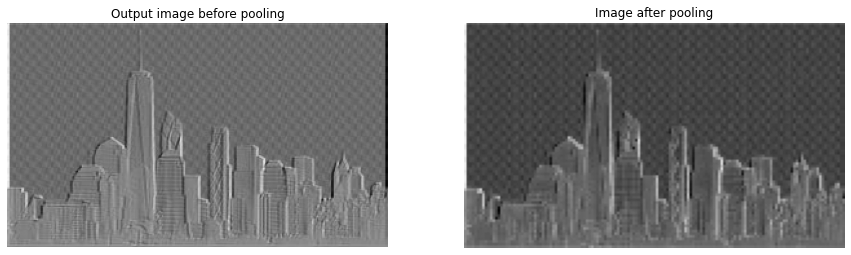

In [ ]:
pooled_img = pool(res, stride=(2, 2))

fig, axes = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0].imshow(res, cmap="gray")
axes[0].axis('off')
axes[0].set_title("Output image before pooling")

axes[1].imshow(pooled_img[:, :, 0], cmap="gray")
axes[1].axis('off')
axes[1].set_title("Image after pooling")

plt.show()

# 3. Convolution layer function

Kernel dimensions: (5, 3, 3, 3)
Output dimensions: (176, 297, 5)


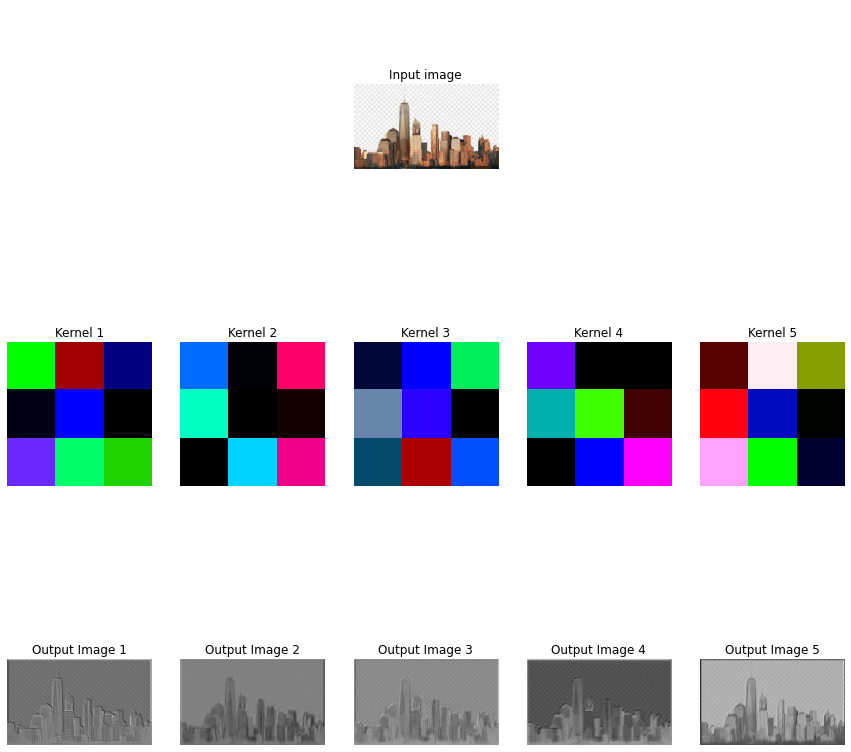

Input image dimensions: (172, 293, 3)
Resulting Dimensions: (176, 297, 5)


In [ ]:
no_of_outputs = 5

multi_kernel, multi_res = convolve(img, img.shape[2], no_of_outputs, padding=(3, 3), nl_activation_func=linear)
print("Kernel dimensions: {}".format(multi_kernel.shape))
print("Output dimensions: {}".format(multi_res.shape))

fig, axes = plt.subplots(3, no_of_outputs)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0, 2].imshow(img)
axes[0, 2].set_title("Input image")

for i in range(no_of_outputs):
  axes[0, i].axis('off')

  axes[1, i].imshow(multi_kernel[i].transpose((1, 2, 0)))
  axes[1, i].axis('off')
  axes[1, i].set_title("Kernel {}".format(i + 1))

  axes[2, i].imshow(multi_res[:, :, i], cmap="gray")
  axes[2, i].axis('off')
  axes[2, i].set_title("Output Image {}".format(i + 1))

plt.show()
print("Input image dimensions: {}".format(img.shape))
print("Resulting Dimensions: {}".format(multi_res.shape))

Output width = $W - k + 2p \over s $ + $1$
= $172 - 3 + 2*3 \over 1$ + $1$ = 176 \
\
Output width = $H - k + 2p \over s $ + $1$
= $293 - 3 + 2*3 \over 1$ + $1$ = 297 \
\
Output channels = 5 (which matches with that of no_of_outputs)

# 4. Pooling layer function

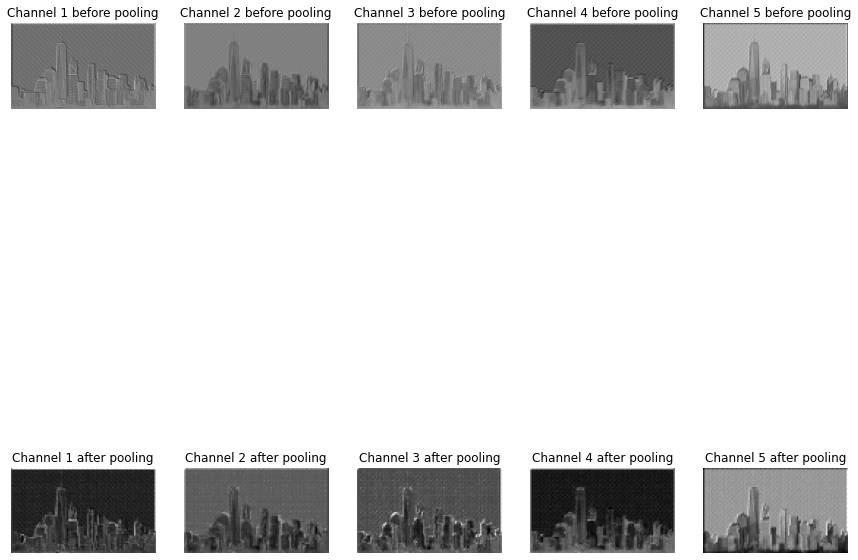

Input volume = (176, 297, 5)
Output_volume = (58, 99, 5)


In [ ]:
multi_pooled_img = pool(multi_res, stride=(3, 3))

fig, axes = plt.subplots(2, no_of_outputs)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(no_of_outputs):
  axes[0, i].imshow(multi_res[:, :, i], cmap="gray")
  axes[0, i].axis('off')
  axes[0, i].set_title("Channel {} before pooling".format(i + 1))

  axes[1, i].imshow(multi_pooled_img[:, :, i], cmap="gray")
  axes[1, i].axis('off')
  axes[1, i].set_title("Channel {} after pooling".format(i + 1))

plt.show()
print("Input volume = {}".format(multi_res.shape))
print("Output_volume = {}".format(multi_pooled_img.shape))

In [ ]:
gap_res = pool(multi_res, stride=(3, 3), global_average_pooling=True)
print("Global average pooling results: {}".format(gap_res))

print("Input volume = {}".format(multi_res.shape))
print("Output_volume = {}".format(gap_res.shape))

Global average pooling results: [[-182.98857381]
 [  10.17555635]
 [ -90.35957179]
 [-497.61453391]
 [ 881.26770551]]
Input volume = (176, 297, 5)
Output_volume = (5, 1)


# 5. Flattening

In [ ]:
def flatten(input_matrix, output_vector_size):
  input_volume = input_matrix.shape[0] * input_matrix.shape[1] * input_matrix.shape[2]
  weights = np.random.randn(output_vector_size, input_volume)
  output_vector = weights @ input_matrix.reshape((input_volume, 1))
  return output_vector

# 6. Multilayer Perceptron (MLP) function

In [ ]:
def MLP(input, hidden_layer_sizes, output_size, nl_activation_func=ReLU):
  no_of_hidden_layers = len(hidden_layer_sizes)
  input_size = input.shape[0]
  hidden_layer_sizes.insert(0, input_size)
  hidden_layer_sizes.append(output_size)
  weights = []
  biases = []
  outputs = []
  activations = [input]
  for i in range(1, len(hidden_layer_sizes)):
    bias = np.random.randn(hidden_layer_sizes[i], 1)
    weight = np.random.randn(hidden_layer_sizes[i], hidden_layer_sizes[i-1])
    output = weight @ activations[-1] + bias
    if i == len(hidden_layer_sizes) - 1:
      activation = softmax(output)
    else:
      activation = nl_activation_func(output)
    biases.append(bias)
    weights.append(weight)
    outputs.append(output)
    activations.append(activation)
  return weights, biases, outputs, activations # outputs[-1] will return the output without softmax function applied to the output layer

# 7. Feed-forward path

In [ ]:
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


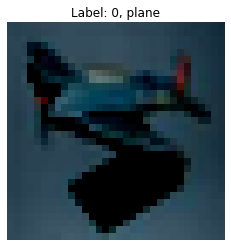

In [ ]:
random_index = random.randrange(50000)
input_img = dataset[random_index][0].permute(1, 2, 0)
output_label = dataset[random_index][1]

plt.imshow(input_img)
plt.axis('off')
plt.title("Label: {}, {}".format(output_label, classes[output_label]))
plt.show()

In [ ]:
def feed_forward_pipeline(input_img, print_verbose=False):
  _, convoluted_img_1 = convolve(input_img, 3, 16, (3, 3), (0, 0), (1, 1), sigmoid)
  if print_verbose:
    print("===> Convolution from dimensions {} to dimensions {}".format(input_img.shape, convoluted_img_1.shape))
  pooled_img_1 = pool(convoluted_img_1, (2, 2), max_pooling, False)
  if print_verbose:
    print("===> Pooling from dimensions {} to dimensions {}".format(convoluted_img_1.shape, pooled_img_1.shape))
  _, convoluted_img_2 = convolve(pooled_img_1, 16, 8, (3, 3), (0, 0), (1, 1), sigmoid)
  if print_verbose:
    print("===> Convolution from dimensions {} to dimensions {}".format(pooled_img_1.shape, convoluted_img_2.shape))
  pooled_img_2 = pool(convoluted_img_2, (2, 2), max_pooling, False)
  if print_verbose:
    print("===> Pooling from dimensions {} to dimensions {}".format(convoluted_img_2.shape, pooled_img_2.shape))
  gap = pool(pooled_img_2, global_average_pooling=True)
  if print_verbose:
    print("===> Global Average Pooling from dimensions {} to dimensions {}".format(pooled_img_2.shape, gap.shape))
  weights, biases, outputs, activations = MLP(gap, [8], 10, sigmoid)
  if print_verbose:
    print("===> MLP with 1 hidden layer from dimensions {} to dimensions {}".format(gap.shape, activations[-1].shape))
  return weights, biases, outputs, activations

In [ ]:
weights, biases, outputs, activations = feed_forward_pipeline(input_img, print_verbose=True)
print("\nOutput from the CNN pipeline is as follows: ")
for i in range(10):
  print("For label {}, the corresponding output is {}".format(i + 1, activations[-1][i]))

===> Convolution from dimensions torch.Size([32, 32, 3]) to dimensions (30, 30, 16)
===> Pooling from dimensions (30, 30, 16) to dimensions (15, 15, 16)
===> Convolution from dimensions (15, 15, 16) to dimensions (13, 13, 8)
===> Pooling from dimensions (13, 13, 8) to dimensions (6, 6, 8)
===> Global Average Pooling from dimensions (6, 6, 8) to dimensions (8, 1)
===> MLP with 1 hidden layer from dimensions (8, 1) to dimensions (10, 1)

Output from the CNN pipeline is as follows: 
For label 1, the corresponding output is [0.00988039]
For label 2, the corresponding output is [0.04892327]
For label 3, the corresponding output is [0.00524028]
For label 4, the corresponding output is [0.86234215]
For label 5, the corresponding output is [0.01658014]
For label 6, the corresponding output is [0.00702172]
For label 7, the corresponding output is [0.0248114]
For label 8, the corresponding output is [0.01103251]
For label 9, the corresponding output is [0.0025001]
For label 10, the corresponding

# 8. Final part

In [ ]:
class_images = {}
for i in range(10):
  class_images[i] = []

class_check = [False] * 10
count = 0
indices = list(range(50000))
random.shuffle(indices)
for i in indices:
  label = dataset[i][1]
  if class_check[label] == False:
    class_images[label].append(dataset[i][0].permute(1, 2, 0))
    if len(class_images[label]) == 3:
      class_check[label] = True
    count += 1
  if count == 30:
    break

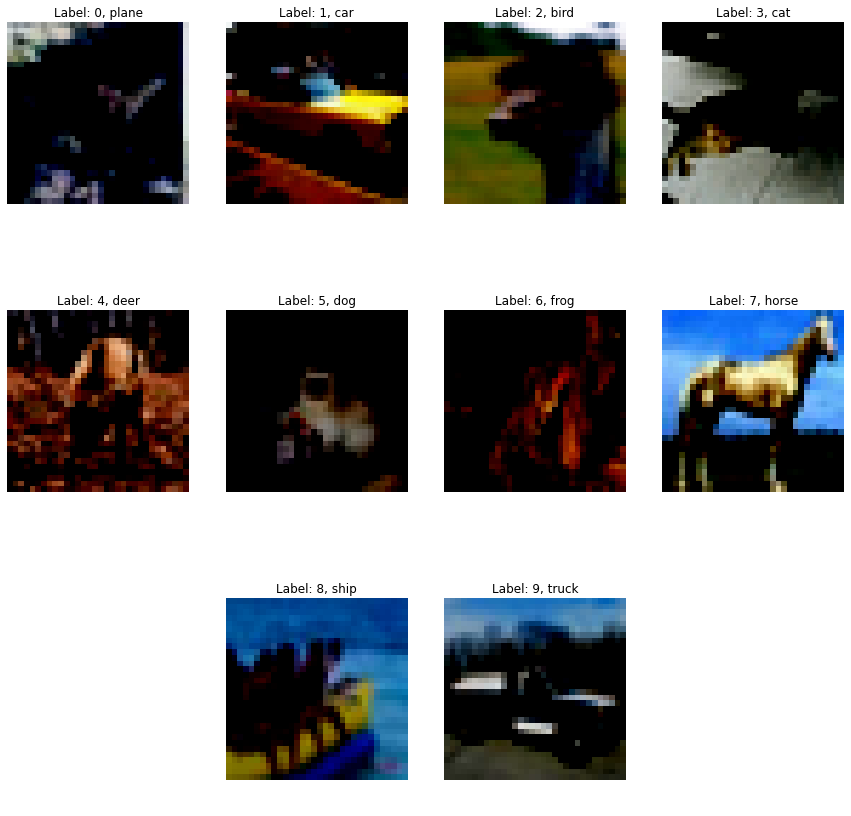

In [ ]:
fig, axes = plt.subplots(3, 4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(10):
  r = i // 4
  c = i % 4
  if r == 2:
    c += 1
  axes[r][c].imshow(class_images[i][0])
  axes[r][c].axis('off')
  axes[r][c].set_title("Label: {}, {}".format(i, classes[i]))

axes[2][0].axis('off')
axes[2][3].axis('off')
plt.show()

In [ ]:
activation_outputs = []
for i in range(10):
  for j in range(3):
    w, b, o, a = feed_forward_pipeline(class_images[i][j], print_verbose=False)
    activation_outputs.append(a[-1])

In [ ]:
for i in range(10):
  print("Output from CNN pipeline for {} is \n{}".format(i+1, activation_outputs[3 * i]))

Output from CNN pipeline for 1 is 
[[0.08087071]
 [0.17513892]
 [0.02645706]
 [0.0063574 ]
 [0.00284343]
 [0.00250674]
 [0.48296282]
 [0.15652205]
 [0.03893519]
 [0.02740568]]
Output from CNN pipeline for 2 is 
[[0.02590065]
 [0.00314008]
 [0.00065992]
 [0.0047426 ]
 [0.02700403]
 [0.04186307]
 [0.14629225]
 [0.4140701 ]
 [0.313388  ]
 [0.0229393 ]]
Output from CNN pipeline for 3 is 
[[3.74952181e-02]
 [2.89823732e-03]
 [6.58880345e-03]
 [6.56301964e-03]
 [3.46094778e-02]
 [9.83041772e-03]
 [2.51190097e-02]
 [8.57038855e-01]
 [3.02485427e-04]
 [1.95544761e-02]]
Output from CNN pipeline for 4 is 
[[0.03151733]
 [0.03279902]
 [0.00460551]
 [0.75810641]
 [0.07059096]
 [0.06622198]
 [0.00944995]
 [0.00353162]
 [0.01718637]
 [0.00599086]]
Output from CNN pipeline for 5 is 
[[0.0100513 ]
 [0.02616488]
 [0.08648608]
 [0.0164533 ]
 [0.00439667]
 [0.00333224]
 [0.06714173]
 [0.18225286]
 [0.58393645]
 [0.01978448]]
Output from CNN pipeline for 6 is 
[[0.21969121]
 [0.01044973]
 [0.0361918 ]
 [0

As we can see from the output vectors of images from 10 different classes, most of the vectors have values ranging between 0.0 and 0.3 with a few exceptions of vectors having some value above 0.5. This shows us that the CNN we built using randomly generated weights and biases cannot specify which class an image belongs to with high certainity and the vectors which have a value greater than 0.5 is just out of pure luck.

In [ ]:
def feed_forward_pipeline_for_PCA(input_img):
  _, convoluted_img_1 = convolve(input_img, 3, 16, (3, 3), (0, 0), (1, 1), sigmoid)
  pooled_img_1 = pool(convoluted_img_1, (2, 2), max_pooling, False)
  _, convoluted_img_2 = convolve(pooled_img_1, 16, 8, (3, 3), (0, 0), (1, 1), sigmoid)
  pooled_img_2 = pool(convoluted_img_2, (2, 2), max_pooling, False)
  gap = pool(pooled_img_2, global_average_pooling=True)
  return gap

In [ ]:
gap_outputs = []
for i in range(10):
  for j in range(3):
    gap_op = feed_forward_pipeline_for_PCA(class_images[i][j])
    gap_outputs.append(gap_op[:, 0])

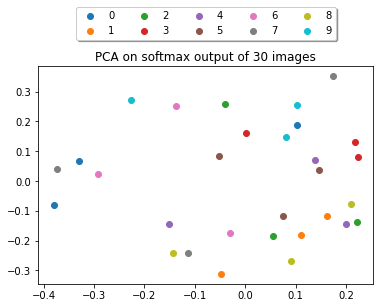

In [ ]:
gap_outputs = np.array(gap_outputs).reshape((30, 8))
output_tensor = torch.from_numpy(gap_outputs)
U, S, V = torch.pca_lowrank(output_tensor, q=2, center=True, niter=30)
for i in range(10):
  plt.scatter(U[i * 3 : i * 3 + 3, 0], U[i * 3 : i * 3 + 3, 1], label="{}".format(i))

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.title('PCA on softmax output of 30 images')
plt.show()

As we can see from the plot, a randomly initialized CNN does not show any discriminability as only feed forward has been implemented and there is no learning happening based on any test dataset. This is visible from the plot because points of same labels are not clustered together in a nearby region. In fact, the points look uniformly distributed and randomly labelled because the network designed cannot dicriminate one label from the other.